## Exploratory Data Analysis

- Antibody usage by checkpoint
- Interface length and residue frequency
- Epitope overlap: common vs. unique

In [2]:
import numpy as numpy
import pandas as pd
import seaborn as sns #for plotting
import matplotlib.pyplot as plt
import random
import os
from scipy.stats import zscore
from collections import Counter
import requests
from Bio.PDB import PDBParser, NeighborSearch

In [3]:
# Define datasets for individual inhibitory checkpoints
data = pd.read_csv('data/ab_ag.tsv', sep='\t')
pd1 = data[data['compound'].str.contains('PD-1', na=False)]
pdl1 = data[data['compound'].str.contains('PD-L1', na=False)]
ctla4 = data[data['compound'].str.contains('CTLA-4', na=False)]
kir = data[data['compound'].str.contains('KIR', na=False)]
lag3 = data[data['compound'].str.contains('LAG', na=False)]
tim3 = data[data['compound'].str.contains('TIM3', na=False)]


# Filter out necessary columns
pd1 = pd1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
pdl1 = pdl1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
ctla4 = ctla4[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
kir = kir[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
lag3 = lag3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
tim3 = tim3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]


combined_dataset = [pdl1, pd1, ctla4, kir, lag3, tim3]

# Shuffle the list randomly
random.shuffle(combined_dataset)

# Concatenate them in the new random order
merged_df = pd.concat(combined_dataset, ignore_index=True)
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)


shuffled_df = shuffled_df[shuffled_df['resolution'] < 3.5]
shuffled_df = shuffled_df.dropna()

## PDB IDs pro Checkpoint geordnet runterladen

In [4]:
checkpoints = ['PD-1', 'PD-L1', 'CTLA-4', 'KIR', 'LAG3', 'TIM3']

pdb_ids = {
    'PD-1': pd1['pdb'].unique().tolist(), # mit variable funktioniert unique nicht
    'PD-L1': pdl1['pdb'].unique().tolist(),
    'CTLA-4': ctla4['pdb'].unique().tolist(),
    'KIR': kir['pdb'].unique().tolist(),
    'LAG3': lag3['pdb'].unique().tolist(),
    'TIM3': tim3['pdb'].unique().tolist(),
}

# Ordner erstellen. Der loop geht über die jeweiligen pdbs der Checkpoints
for checkpoint in checkpoints:
    save_folder = f'pdbs/{checkpoint}' # Define save directory
    os.makedirs(save_folder, exist_ok=True) # make new directory with name above if doesn't exist
    for pdb_id in pdb_ids[checkpoint]: 
        pdb_id = pdb_id.lower()
        url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
        response = requests.get(url)
        if response.status_code == 200:
            with open(os.path.join(save_folder, f"{pdb_id}.pdb"), "w") as f:
                f.write(response.text)
            print(f"Downloaded: {pdb_id}.pdb")
        else:
            print(f"Failed to download: {pdb_id}.pdb (status code: {response.status_code})") 

Downloaded: 8u31.pdb
Downloaded: 8u32.pdb
Downloaded: 8gy5.pdb
Downloaded: 7wsl.pdb
Downloaded: 8as0.pdb
Downloaded: 5ggs.pdb
Downloaded: 7cgw.pdb
Downloaded: 5jxe.pdb
Downloaded: 5ggr.pdb
Downloaded: 5b8c.pdb
Downloaded: 6jjp.pdb
Downloaded: 5wt9.pdb
Downloaded: 7bxa.pdb
Downloaded: 7e9b.pdb
Downloaded: 7wvm.pdb
Downloaded: 7cu5.pdb
Downloaded: 6k0y.pdb
Downloaded: 6xkr.pdb
Downloaded: 8rpb.pdb
Downloaded: 5xj4.pdb
Downloaded: 7yds.pdb
Downloaded: 5ggt.pdb
Downloaded: 5grj.pdb
Downloaded: 5x8l.pdb
Downloaded: 5x8m.pdb
Downloaded: 5xxy.pdb
Downloaded: 9dq3.pdb
Downloaded: 9dq4.pdb
Downloaded: 9dq5.pdb
Downloaded: 5xj3.pdb
Downloaded: 6rp8.pdb
Downloaded: 7dv4.pdb
Downloaded: 5ggv.pdb
Downloaded: 7su0.pdb
Downloaded: 5tru.pdb
Downloaded: 6xy2.pdb
Downloaded: 7su1.pdb
Downloaded: 7elx.pdb
Downloaded: 8tui.pdb
Downloaded: 7tzh.pdb
Downloaded: 7tzg.pdb
Downloaded: 6txz.pdb


## Define interface
- Analysieren der Protein-Protein-Interaktion zwischen einem Antikörper und einem Antigen
- Identifizieren der Residuen an der Grenzfläche (innerhalb 5 A). 
- (Bidirektional, weil nicht garantiert ist, dasss beide Richtungen symmetrisch sind)

In [5]:
def analyze_interface_residues(pdb_path, heavy_chain, light_chain, antigen_chain, cutoff=5.0): # pdb_path: Pfad zur PDB-Datei mit 3D-Struktur
    pdb_id = os.path.basename(pdb_path).replace(".pdb", "")
    parser = PDBParser(QUIET=True) # Die PDB-Datei wird geladen und das erste Modell ausgewählt
    structure = parser.get_structure(pdb_id, pdb_path)
    model = structure[0]

    ab_chains = [heavy_chain, light_chain] # Ketten-IDs definieren
    ag_chain = antigen_chain

    ab_atoms, ag_atoms = [], [] # Atome extrahieren. Werden als Liste gesammelt.
    ab_residues, ag_residues = set(), set() 

    for chain in model: # Loop über alle Ketten im Modell. (Sammeln alle Atome, die zu den relevanten Ketten im Molekül gehören (ab (heavy und light) und ag)
        if chain.id in ab_chains: # Wenn Kette Teil des ab ist (heavy oder light)
            ab_atoms.extend(chain.get_atoms()) # Alle Atome dieser Kette in die ab_atoms-Liste
        elif chain.id == ag_chain: # Wenn Kette das ag ist
            ag_atoms.extend(chain.get_atoms()) # Alle Atome dieser Kette in die ag_atoms-Liste

    ns = NeighborSearch(ab_atoms + ag_atoms) # Suche nach Atomen in der Nähe

    for atom in ab_atoms: # Interface-Residuen identifizieren: Für jedes ab-Atom, finde ag-Atome innerhalb von 5A. Loop geht über alle Atome die im file sind
        for neighbor in ns.search(atom.coord, cutoff):
            res = neighbor.get_parent()
            if res.get_parent().id == ag_chain:
                ag_residues.add(res)

    for atom in ag_atoms: # Das selbe wie oben für ag Atome: finde nahe ag Residuen
        for neighbor in ns.search(atom.coord, cutoff):
            res = neighbor.get_parent()
            if res.get_parent().id in ab_chains:
                ab_residues.add(res)
    rows = []

    ab_freq = Counter(res.resname for res in ab_residues) # Count frequency, residues die am häufigsten vorkommen nehmen und alle daten die innerhalb von 5A bekommen
    ag_freq = Counter(res.resname for res in ag_residues)

    for res in ab_residues:
        rows.append({
            "pdb_id": pdb_id,
            "chain_id": res.get_parent().id,
            "partner_type": "antibody",
            "residue_name": res.resname,
            "residue_number": res.id[1],
            "residue_id": f"{res.id[1]}{res.id[2].strip()}",
            "chain_pair": f"{heavy_chain}{light_chain}-{antigen_chain}",
            "interface_distance": cutoff,
            "residue_frequency": ab_freq[res.resname]
        })

    for res in ag_residues:
        rows.append({
            "pdb_id": pdb_id,
            "chain_id": res.get_parent().id,
            "partner_type": "antigen",
            "residue_name": res.resname,
            "residue_number": res.id[1],
            "residue_id": f"{res.id[1]}{res.id[2].strip()}",
            "chain_pair": f"{heavy_chain}{light_chain}-{antigen_chain}",
            "interface_distance": cutoff,
            "residue_frequency": ag_freq[res.resname]
        })

    return rows # Gibt eine Liste aller Grenzflächen-Residuen mit Daten zurück

## Speichern der Residue Daten in csv

In [6]:
current_checkpoint = 'pd1' # wechseln 
folder_path = f"structures/{current_checkpoint}"
ckpt_ids = os.listdir(folder_path)
all_interface_rows = []

for ckpt_id in ckpt_ids:
    pdb_path = os.path.join(folder_path, ckpt_id) #structures/pd1/5b8c.pdb 
    pdb_id = ckpt_id.replace(".pdb", "") #5b8c

    try: #wenn pdbid existiert, dann gibt es die wer
        H = pd1[pd1['pdb'] == pdb_id]['Hchain'].values[0] # wechseln 
        L = pd1[pd1['pdb'] == pdb_id]['Lchain'].values[0] # wechseln
        A = pd1[pd1['pdb'] == pdb_id]['antigen_chain'].values[0] # wechseln

        rows = analyze_interface_residues(pdb_path, H, L, A) #gibt werte, die wir für die funktion brauchen 
        all_interface_rows.extend(rows) #verknüpft alle reihen

    except Exception as e: #wenn es kein pdb oder kein file
        print(f"Error with {ckpt_id}: {e}")

#Save full long-format table
df_out = pd.DataFrame(all_interface_rows) #in df umwandeln
output_folder = f"data/{current_checkpoint}" #definiert output für csv
os.makedirs(output_folder, exist_ok=True) # make Ordner, falls nciht existiert


df_out.to_csv(f"{output_folder}/{current_checkpoint}_interface_residues.csv", index=False) #erstellt ein csv (excel) file
print(f"Saved detailed data to {current_checkpoint}_interface_residues.csv")


# Create pivot summary
df_pivot = df_out.groupby(['residue_name', 'pdb_id'])['residue_name'].count().unstack(fill_value=0) #wandelt die pdb ids in spalten um und berechnet die Häufigkeit der residuen pro pdb id. unstack fill 0 setzt eine 0, wenn es nicht vorkommt
df_pivot.to_csv(f"{output_folder}/{current_checkpoint}_residue_frequencies_pivot.csv")

print(f"Saved pivot summary to {current_checkpoint}_residue_frequencies_pivot.csv")

Error with 5b8c_epitope.pse: index 0 is out of bounds for axis 0 with size 0
Error with 5jxe_epitope.pse: index 0 is out of bounds for axis 0 with size 0
Error with 7bxa_epitope.pse: index 0 is out of bounds for axis 0 with size 0
Error with 5ggs_epitope.pse: index 0 is out of bounds for axis 0 with size 0
Error with 5wt9_epitope.pse: index 0 is out of bounds for axis 0 with size 0
Error with 6xkr_epitope.pse: index 0 is out of bounds for axis 0 with size 0
Error with 7wsl_epitope.pse: index 0 is out of bounds for axis 0 with size 0
Error with 6k0y_epitope.pse: index 0 is out of bounds for axis 0 with size 0
Error with 7cgw_epitope.pse: index 0 is out of bounds for axis 0 with size 0
Error with 8gy5_epitope.pse: index 0 is out of bounds for axis 0 with size 0
Error with 7wvm_epitope.pse: index 0 is out of bounds for axis 0 with size 0
Error with 5ggr_epitope.pse: index 0 is out of bounds for axis 0 with size 0
Error with 7cu5_epitope.pse: index 0 is out of bounds for axis 0 with size 0

## Heatmaps

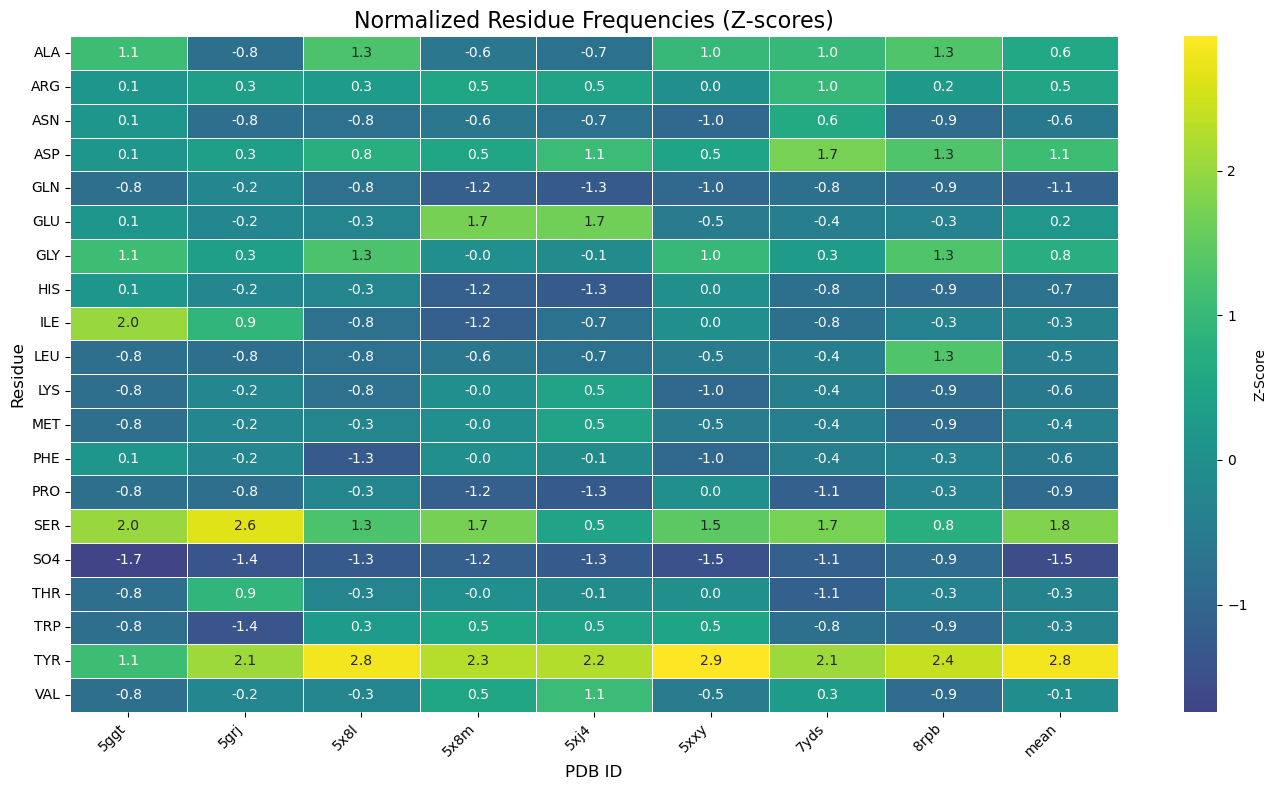

In [7]:
# Load pivoted frequency table
variable = 'pdl1'
df = pd.read_csv(f"data/{variable}/{variable}_residue_frequencies_pivot.csv", index_col=0)

# Z-score across all values
df_z = df.apply(zscore, axis=0)

plt.figure(figsize=(14, 8))

sns.heatmap(
    df_z,
    cmap="viridis", #Farbe
    center=0,
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"label": "Z-Score"}
)

plt.title("Normalized Residue Frequencies (Z-scores)", fontsize=16)
plt.ylabel("Residue", fontsize=12)
plt.xlabel("PDB ID", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"plots/{variable}_heatmap.pdf", bbox_inches = "tight")
plt.show()

# Mean heatmap values

In [8]:
checkpoints = ['pd1', 'pdl1', 'ctla4', 'kir', 'lag3', 'tim3']
for checkpoint in checkpoints:    
    read_folder = f'data/{checkpoint}/{checkpoint}_residue_frequencies_pivot.csv'

    df= pd.read_csv(read_folder, index_col=0)
    df['mean'] = df.mean(axis = 1) #berechnet mittelwert pro zeile
    df.to_csv(read_folder, sep = ',')

Bar plot: Durchschnittliche Anzahl der Aminosäuren der jeweiligen Checkpoints

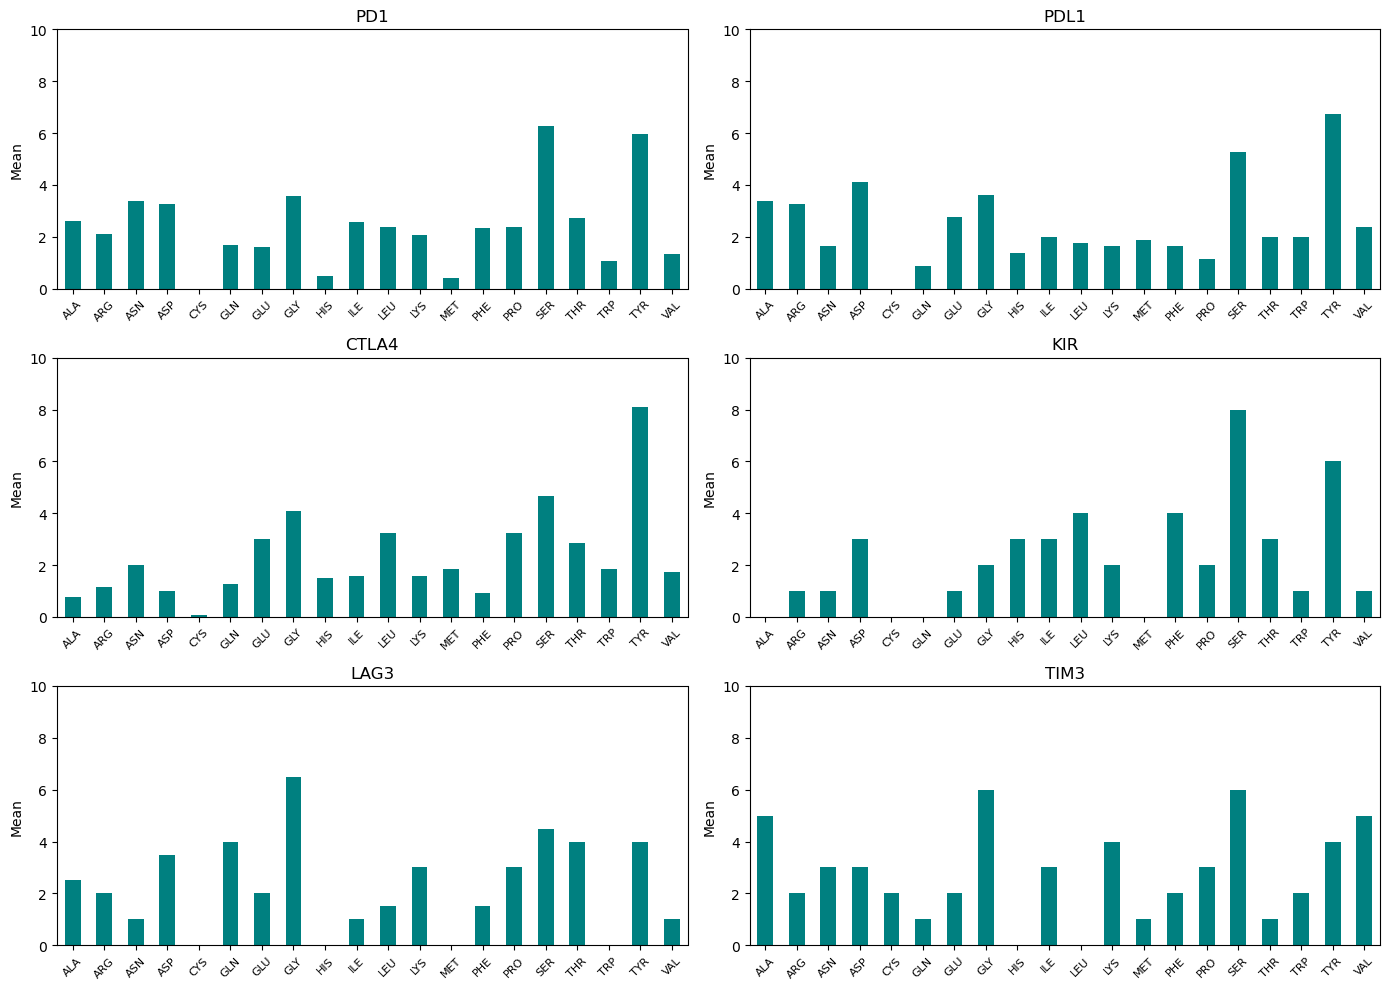

In [10]:
all_residues = [
    'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE',
    'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL' #Liste aller Aminosäuren, die im Plot enthalten sein sollen
]

fig, axes = plt.subplots(3, 2, figsize=(14, 10)) #Erstellt ein 3x2-Gitter von Subplots für die Visualisierung
axes = axes.flatten()

for i, cp in enumerate(checkpoints):
    file_path = f'data/{cp}/{cp}_residue_frequencies_pivot.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0)
        df = df.reindex(all_residues)  # Adds missing residues with NaN
        ax = axes[i]
        df['mean'].plot(kind='bar', ax=ax, color='teal')
        ax.set_title(f'{cp.upper()}')
        ax.set_ylim(0, 10)
        ax.set_xlabel('')
        ax.set_ylabel('Mean')
        ax.tick_params(axis='x', labelrotation=45, labelsize=8)

# Remove any unused subplots
for j in range(len(checkpoints), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(f"plots/checkpoint_AA_freq_barplot.pdf")
plt.show()

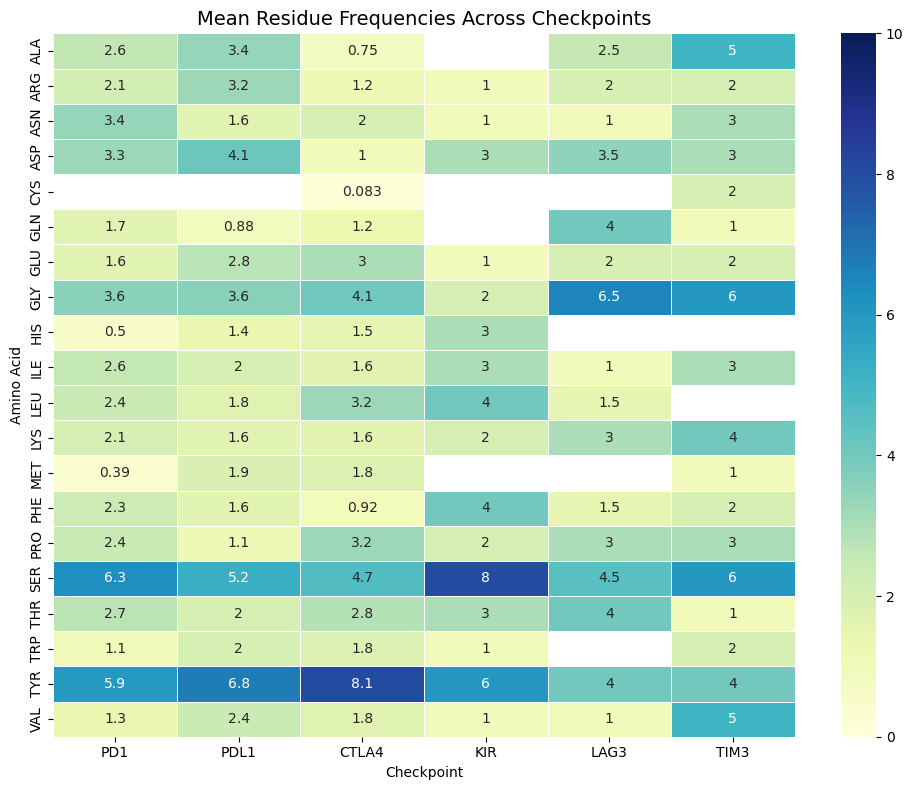

In [11]:
heatmap_data = pd.DataFrame(index=all_residues)

for cp in checkpoints:
    file_path = f'data/{cp}/{cp}_residue_frequencies_pivot.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0)
        df = df.reindex(all_residues)  # ensure consistent order
        heatmap_data[cp.upper()] = df['mean']

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", vmin=0, vmax=10, linewidths=0.5)
plt.title("Mean Residue Frequencies Across Checkpoints", fontsize=14)
plt.xlabel("Checkpoint")
plt.ylabel("Amino Acid")
plt.tight_layout()
plt.savefig("plots/checkpoint_AA_freq_heatmap.pdf", dpi=300)
plt.show()


## Aminosäurensequenzen den Checkpoints zuzuordnen
- Versuch (hat noch nicht funktioniert - es gibt nur 8)
- Mittel pseudoAAC (Optionen gegoogelt)

In [12]:
import glob
from propy.PseudoAAC import GetPseudoAAC, _Hydrophobicity, _hydrophilicity, _residuemass
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [13]:
three_to_one = {
    'ALA':'A','ARG':'R','ASN':'N','ASP':'D','CYS':'C',
    'GLU':'E','GLN':'Q','GLY':'G','HIS':'H','ILE':'I',
    'LEU':'L','LYS':'K','MET':'M','PHE':'F','PRO':'P',
    'SER':'S','THR':'T','TRP':'W','TYR':'Y','VAL':'V'
}
AAP = [_Hydrophobicity, _hydrophilicity, _residuemass]

def analyze_interface_and_pseaac(pdb_path, heavy_chain, light_chain, antigen_chain, cutoff=5.0):

    lamda = 10
    weight = 0.05

    pdb_id = os.path.basename(pdb_path).replace(".pdb", "")
    parser = PDBParser(QUIET=True)
    struct = parser.get_structure(pdb_id, pdb_path)
    model = struct[0]

    ab_chains = [heavy_chain, light_chain]
    ag_chain_id = antigen_chain

    ab_atoms, ag_atoms = [], []
    ab_residues, ag_residues = set(), set()

    for chain in model:
        if chain.id in ab_chains:
            ab_atoms.extend(chain.get_atoms())
        elif chain.id == ag_chain_id:
            ag_atoms.extend(chain.get_atoms())

    ns = NeighborSearch(ab_atoms + ag_atoms)

    # Identify antigen interface residues
    for atom in ab_atoms:
        for neigh in ns.search(atom.coord, cutoff):
            res = neigh.get_parent()
            if res.get_parent().id == ag_chain_id:
                ag_residues.add(res)
    # Identify antibody interface residues
    for atom in ag_atoms:
        for neigh in ns.search(atom.coord, cutoff):
            res = neigh.get_parent()
            if res.get_parent().id in ab_chains:
                ab_residues.add(res)

    # Prepare summary rows
    rows = []
    ab_freq = Counter(res.resname for res in ab_residues)
    ag_freq = Counter(res.resname for res in ag_residues)

    for res_set, freq_dict, partner in [
        (ab_residues, ab_freq, "antibody"),
        (ag_residues, ag_freq, "antigen")
    ]:
        for res in res_set:
            rows.append({
                "pdb_id": pdb_id,
                "chain_id": res.get_parent().id,
                "partner_type": partner,
                "res_name": res.resname,
                "res_num": res.id[1],
                "res_id": f"{res.id[1]}{res.id[2].strip()}",
                "chain_pair": f"{heavy_chain}{light_chain}-{antigen_chain}",
                "distance_cutoff": cutoff,
                "frequency": freq_dict[res.resname]
            })

    # Build the antigen epitope sequence (ordered)
    iface_ag = sorted(ag_residues, key=lambda r: r.id[1])
    epitope_seq = ''.join(three_to_one.get(res.resname, 'X') for res in iface_ag)

#    Remove unknowns:
    clean_seq = epitope_seq.replace('X', '')
    epitope_seq = clean_seq

    # Compute PseAAC for the epitope sequence
    pseaac_features = {}
    if len(epitope_seq) >= lamda + 1:
        pseaac_features = GetPseudoAAC(epitope_seq, lamda=lamda, weight=weight, AAP=AAP)
    else:
        print(f"{pdb_id}: epitope too short ({len(epitope_seq)} < {lamda+1})")
        pseaac_features = {}

    return rows, epitope_seq, pseaac_features

In [14]:
checkpoints = ['PD-1', 'PD-L1', 'CTLA-4', 'KIR', 'LAG3', 'TIM3']

all_rows = []
feature_dicts = [] # here are pseaac results saved
labels = [] # which checkpoint they bind to --> in this case should all be pd1

for checkpoint in checkpoints:  # e.g., ['pd1', 'tim3']
    pdb_dir = os.path.join("pdbs", checkpoint)
    for pdb_file in os.listdir(pdb_dir):
        if not pdb_file.endswith(".pdb"):
            continue

        pdb_path = os.path.join(pdb_dir, pdb_file)
        pdb_id = os.path.splitext(pdb_file)[0]
        
        matches = shuffled_df[shuffled_df['pdb'] == pdb_id]
        if matches.empty:
            print(f"WARNING: {pdb_id} not found in DataFrame — skipping")
            continue

        row = matches.iloc[0]
        H, L, A = row['Hchain'], row['Lchain'], row['antigen_chain']
        rows, seq, pseaac = analyze_interface_and_pseaac(pdb_path, H, L, A)
        
        if not pseaac:
            print(f"Skipping {pdb_id}: epitope_seq='{seq}', length={len(seq)}, pseaac empty")
            continue  # skip if epitope too short
        
        # Interface freq features already in rows: extract antigen freq per amino acid:
        ag_freq = {f"{aa}_freq": 0 for aa in three_to_one.values()}
        for r in rows:
            if r["partner_type"] == "antigen":
                aa = three_to_one.get(r["res_name"], None)
                if aa:
                    ag_freq[f"{aa}_freq"] += 1

        feature_dicts.append({**pseaac, **ag_freq})
        labels.append(checkpoint)  # checkpoint label
        all_rows.extend(rows)

# Build DataFrame and train logistic regression:
df = pd.DataFrame(feature_dicts)
df["Checkpoint"] = labels

X = df.drop(columns=["Checkpoint"])
y = df["Checkpoint"]

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

      CTLA-4       1.00      1.00      1.00         2
        PD-1       1.00      1.00      1.00         3
       PD-L1       1.00      1.00      1.00         3

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [15]:
checkpoints_pattern = r'\b(PD-1|PD-L1|CTLA-4|KIR2DL3|TIM3)\b'
shuffled_df['checkpoint'] = shuffled_df['compound'].str.extract(checkpoints_pattern, expand=False)
shuffled_df[shuffled_df['checkpoint']=='TIM3']


,pdb,Hchain,Lchain,antigen_chain,antigen_type,antigen_name,compound,resolution,method,checkpoint
7,6txz,I,M,B,protein,hepatitis a virus cellular receptor 2,FAB PART OF M6903 IN COMPLEX WITH HUMAN TIM3,3.06,X-RAY DIFFRACTION,TIM3
39,6txz,H,L,A,protein,hepatitis a virus cellular receptor 2,FAB PART OF M6903 IN COMPLEX WITH HUMAN TIM3,3.06,X-RAY DIFFRACTION,TIM3
49,6txz,J,N,C,protein,hepatitis a virus cellular receptor 2,FAB PART OF M6903 IN COMPLEX WITH HUMAN TIM3,3.06,X-RAY DIFFRACTION,TIM3
80,6txz,K,O,D,protein,hepatitis a virus cellular receptor 2,FAB PART OF M6903 IN COMPLEX WITH HUMAN TIM3,3.06,X-RAY DIFFRACTION,TIM3


## Clustering
- Wie ähnlich sind die Checkpoints basierend auf der Komposition von Aminosäuren
- Matrix mit allen pdbs als Zeilen, die Spalten sind die Häufigkeiten der Aminosäuren und der Name des Checkpoints

In [74]:
# Erstellen von ordered_df (transponierte Matrix mit allen pdbs von allen Checkpoints mit den Frequencies der Aminosäuren )

# Alle Frequenz-DataFrames laden
ctla4_aa_freq = pd.read_csv('data/ctla4/ctla4_residue_frequencies_pivot.csv', index_col='residue_name')
kir_aa_freq = pd.read_csv('data/kir/kir_residue_frequencies_pivot.csv', index_col='residue_name')
lag3_aa_freq = pd.read_csv('data/lag3/lag3_residue_frequencies_pivot.csv', index_col='residue_name')
pd1_aa_freq = pd.read_csv('data/pd1/pd1_residue_frequencies_pivot.csv', index_col='residue_name')
pdl1_aa_freq = pd.read_csv('data/pdl1/pdl1_residue_frequencies_pivot.csv', index_col='residue_name')
tim3_aa_freq = pd.read_csv('data/tim3/tim3_residue_frequencies_pivot.csv', index_col='residue_name')

# Funktion: DataFrame transponieren, PDB-Namen als Spalte, Checkpoint hinzufügen
def reshape(df, checkpoint_name):
    df = df.T  # Zeilen = PDBs, Spalten = Aminosäuren
    df['pdb'] = df.index  # PDB-Spalte aus Index erzeugen
    df['checkpoint'] = checkpoint_name  # Checkpoint-Spalte
    return df.reset_index(drop=True)

# Alle DataFrames in ein großes DataFrame umwandeln
dfs = [
    reshape(ctla4_aa_freq, 'ctla4'),
    reshape(kir_aa_freq, 'kir'),
    reshape(lag3_aa_freq, 'lag3'),
    reshape(pd1_aa_freq, 'pd1'),
    reshape(pdl1_aa_freq, 'pdl1'),
    reshape(tim3_aa_freq, 'tim3'),
]

# Alles zusammenfügen
combined_df = pd.concat(dfs, ignore_index=True)

# Liste der 20 Standard-Aminosäuren
aa_list = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 
           'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 
           'THR', 'TRP', 'TYR', 'VAL']

# Neue Spaltenreihenfolge: pdb zuerst, dann die Aminosäuren, checkpoint zuletzt
new_column_order = ['pdb'] + aa_list + ['checkpoint']

# DataFrame umsortieren (pdbs sind 1. Spalte und Checkpoints letzte Spalte)
ordered_df = combined_df[new_column_order]

ordered_df = ordered_df[ordered_df['pdb']!= 'mean']

# In CSV speicher
ordered_df.to_csv('combined_ordered.csv', index=False)


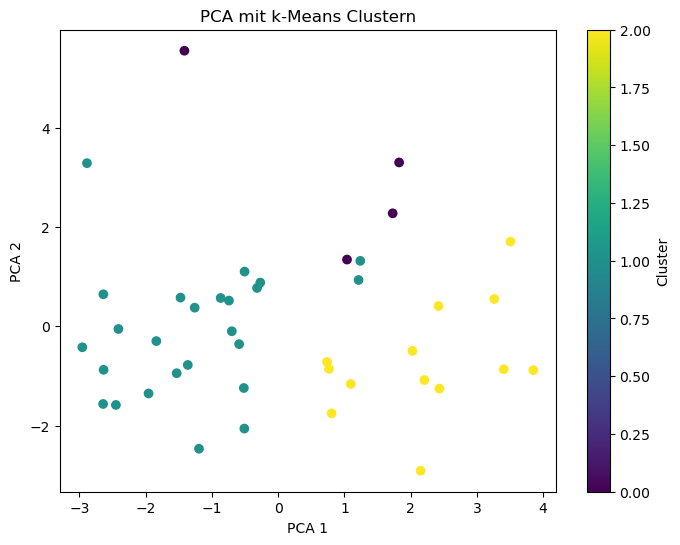

Anzahl NaNs nach Cleaning: 0


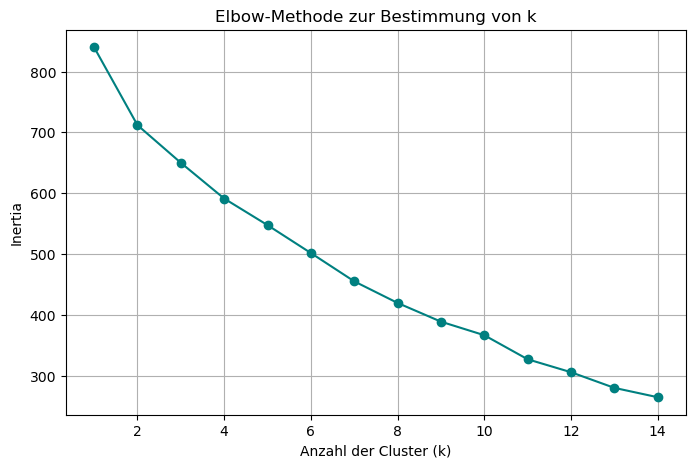

In [75]:
# PCA mit k-means (und Elbow)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Features extrahieren (ohne pdb und checkpoint)
features = ordered_df.drop(columns=['pdb', 'checkpoint'])

# Fehlende Werte mit 0 ersetzen
features = features.fillna(0)

# Skalieren (sehr wichtig für k-Means)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# K-Means Clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
ordered_df['cluster'] = kmeans.fit_predict(features_scaled)

# PCA für 2D-Plot
pca = PCA(n_components=2)
components = pca.fit_transform(features_scaled)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(components[:,0], components[:,1], c=ordered_df['cluster'], cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Cluster')
plt.title('PCA mit k-Means Clustern')
plt.show()

# CSV EINLESEN 
df = pd.read_csv('combined_ordered.csv')

# NaN PROBLEM LÖSEN 
# Entferne unerwünschte Spalten, falls sie doch noch drin sind
df = df.drop(columns=['HOH', 'NAG', 'SO4', 'EDO'], errors='ignore')

# Alle NaNs mit 0 ersetzen
df = df.fillna(0)

# FEATURES EXTRAHIEREN (ohne pdb und checkpoint) 
features = df.drop(columns=['pdb', 'checkpoint'])

# FEATURES SCALEN
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Prüfen, ob NaNs noch vorhanden (muss 0 sein)
print("Anzahl NaNs nach Cleaning:", np.isnan(features_scaled).sum())

# Elbow zur Bestimmung von k
inertia = []
k_values = range(1, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker='o', color= 'teal')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow-Methode zur Bestimmung von k')
plt.grid(True)
plt.show()


Clustering Results interpretieren

In [73]:
ordered_df

residue_name,pdb,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,...,MET,PHE,PRO,SER,THR,TRP,TYR,VAL,checkpoint,cluster
0,5ggv,2.0,2.0,3.0,2.0,0.0,3.0,3.0,4.0,0.0,...,2.0,1.0,4.0,5.0,4.0,1.0,12.0,1.0,ctla4,2
1,5tru,1.0,1.0,2.0,0.0,0.0,1.0,3.0,5.0,1.0,...,2.0,1.0,3.0,7.0,0.0,2.0,8.0,1.0,ctla4,2
2,5xj3,0.0,1.0,1.0,1.0,0.0,1.0,3.0,4.0,0.0,...,2.0,1.0,3.0,6.0,4.0,2.0,8.0,1.0,ctla4,2
3,6rp8,0.0,1.0,2.0,0.0,0.0,1.0,3.0,4.0,1.0,...,2.0,1.0,3.0,6.0,2.0,2.0,8.0,1.0,ctla4,2
4,6xy2,1.0,0.0,4.0,1.0,0.0,0.0,0.0,3.0,2.0,...,1.0,0.0,4.0,3.0,1.0,2.0,11.0,0.0,ctla4,2
5,7dv4,1.0,2.0,2.0,2.0,1.0,0.0,3.0,3.0,1.0,...,2.0,1.0,1.0,5.0,3.0,0.0,5.0,2.0,ctla4,0
6,7elx,1.0,1.0,1.0,0.0,0.0,1.0,3.0,5.0,1.0,...,2.0,1.0,3.0,7.0,4.0,2.0,8.0,3.0,ctla4,2
7,7su0,1.0,1.0,1.0,1.0,0.0,2.0,5.0,5.0,3.0,...,2.0,1.0,3.0,4.0,5.0,2.0,7.0,1.0,ctla4,2
8,7su1,1.0,1.0,1.0,0.0,0.0,0.0,4.0,3.0,3.0,...,2.0,1.0,2.0,2.0,2.0,2.0,6.0,2.0,ctla4,2
9,9dq3,0.0,2.0,1.0,1.0,0.0,2.0,3.0,5.0,2.0,...,2.0,0.0,3.0,3.0,2.0,3.0,8.0,3.0,ctla4,2
